In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import mudata as md
import networkx as nx
import matplotlib.pyplot as plt

import gc
import sys
sys.path.append('../')

from utils.gglasso_pipeline import gg_lasso_network_analysis
from utils.utils import calc_sparsity
from latentcor import latentcor

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### KP

In [2]:
ec_mudata = md.read("../data/preprocessed/ec_mudata_preprocessed.h5mu")
ec_mudata

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\mudata\_core\mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 2507 × 2919
  3 modalities
    all_genes:	2507 x 2622
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc1_genes:	2507 x 245
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'
    gc5_genes:	2504 x 52
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [3]:
print("Sparsity:\t\t", calc_sparsity(ec_mudata["gc5_genes"].X.A))
print("Mean counts per gene:\t", np.mean(np.sum(ec_mudata["gc5_genes"].X.A, axis=1)))
print("Median counts per gene:\t", np.median(np.sum(ec_mudata["gc5_genes"].X.A, axis=1)))
print("Mean genes per cell: \t", np.mean(np.sum(ec_mudata["gc5_genes"].X.A, axis=0)))
print("Median genes per cell:\t", np.median(np.sum(ec_mudata["gc5_genes"].X.A, axis=0)))

Sparsity:		 0.8612066846891128
Mean counts per gene:	 8.711262
Median counts per gene:	 7.0
Mean genes per cell: 	 419.48077
Median genes per cell:	 322.0


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


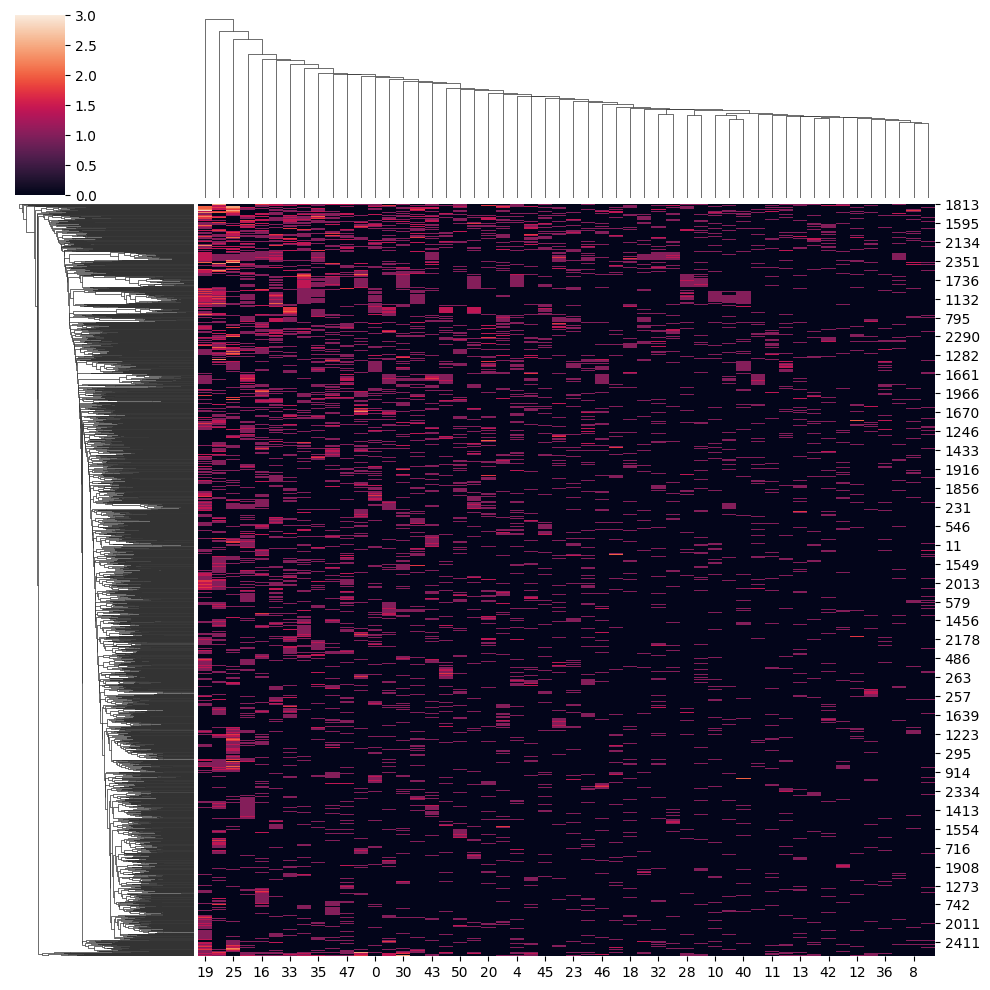

In [4]:
sns.clustermap(ec_mudata["gc5_genes"].layers['sqrt_counts'].A)

## mRNA analysis

In [5]:
ec_mudata["gc5_genes"].var["rRNA"].value_counts()

rRNA
True     28
False    24
Name: count, dtype: int64

In [6]:
ec_mrna = ec_mudata["gc5_genes"][:, ~ec_mudata["gc5_genes"].var["rRNA"]].copy()
ec_mrna

AnnData object with n_obs × n_vars = 2504 × 24
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

In [27]:
ec_rrna = ec_mudata["gc5_genes"][:, ec_mudata["gc5_genes"].var["rRNA"]].copy()
ec_rrna

AnnData object with n_obs × n_vars = 2504 × 28
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'outlier', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'protein_name', 'rRNA', 'PC_lev0', 'PC_lev1', 'PC_lev2', 'PC_lev3', 'PC_lev4', 'PC_lev5', 'PC_lev6', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'sqrt_counts'

### Estimating latent correlation with latentcor

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


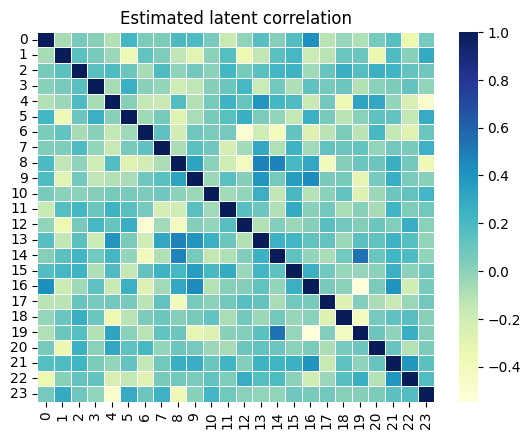

In [7]:
tps = ['tru' for i in range(ec_mrna.shape[1])]
ec_est = latentcor(ec_mrna.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

### Single Graphical Lasso with GGL
Modelselection for lambda based on eBIC

In [8]:
ec_ggl_latentcor = gg_lasso_network_analysis(N=ec_mrna.shape[0], estimate=ec_est)
ec_ggl_latentcor.create_problem(S_col="R", latent=False)
ec_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations wi

In [9]:
ec_sol_latentcor = ec_ggl_latentcor.P.solution.precision_ * -1

<Axes: >

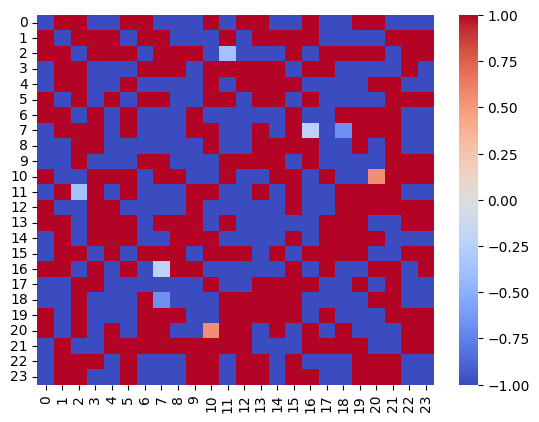

In [10]:
sns.heatmap(ec_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

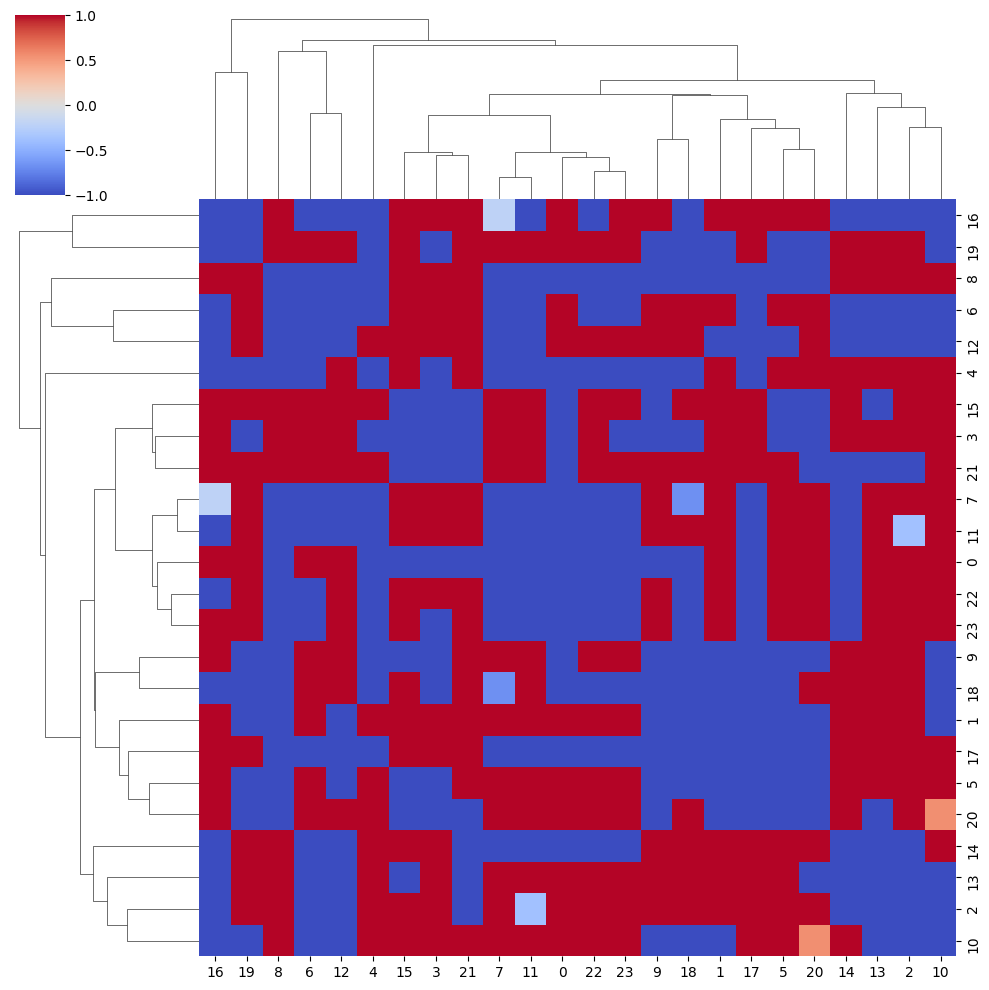

In [11]:
sns.clustermap(ec_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

### Plotting the resulting network

In [24]:
def extract_part(text):
    return ' '.join(text.split()[1:-5])

ec_mrna.var["short_protein_name"] = ec_mrna.var["protein_name"].apply(lambda x: extract_part(x))

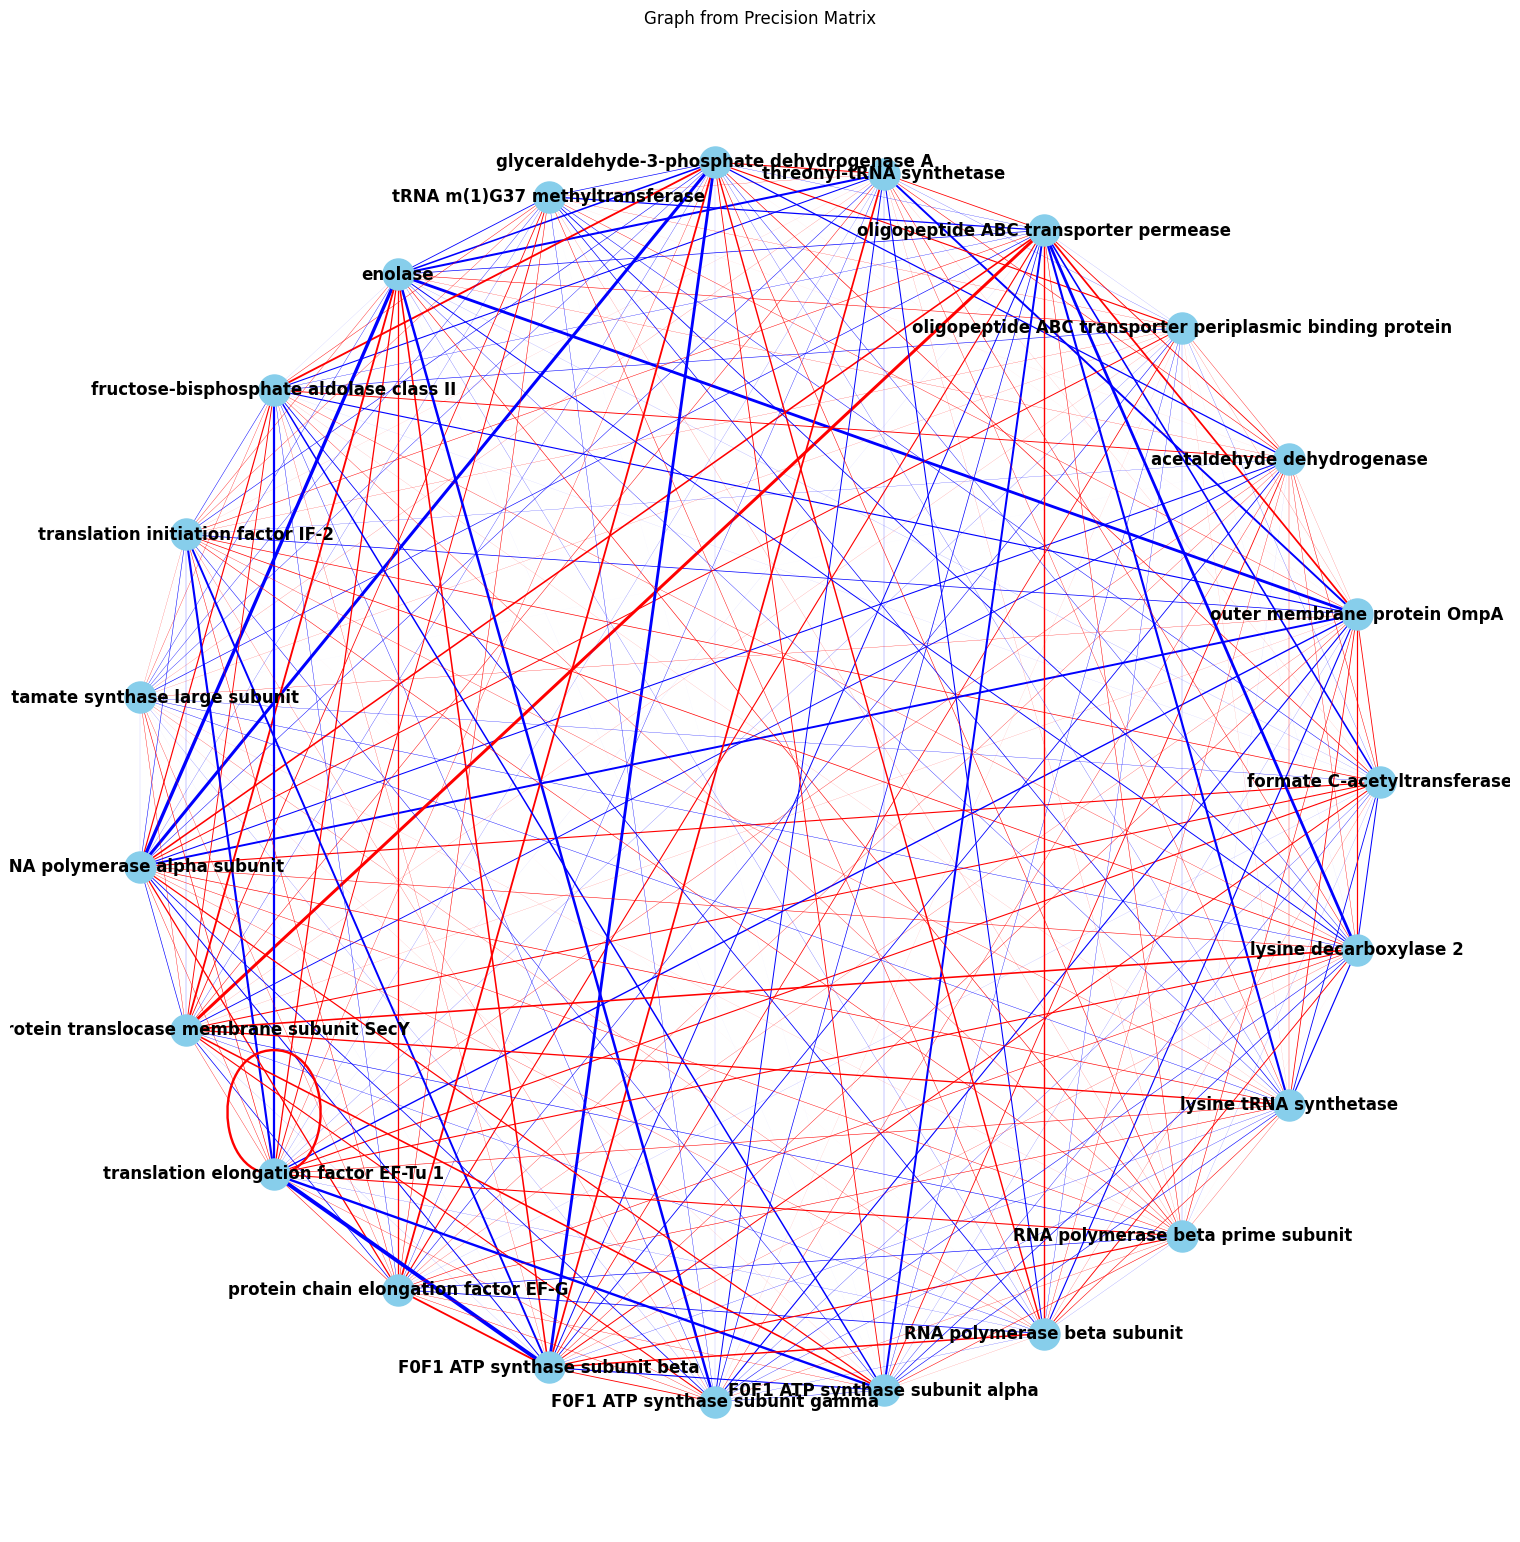

In [26]:
ec_G = nx.Graph()

# Add nodes to the graph
for idx, row in ec_mrna.var.iterrows():
    ec_G.add_node(row['short_protein_name'])

# Add edges to the graph based on the weights
n = len(ec_mrna.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = ec_sol_latentcor[i, j]
        if weight != 0:
            ec_G.add_edge(ec_mrna.var.iloc[i]['short_protein_name'], ec_mrna.var.iloc[j]['short_protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight


# Draw the graph
pos = nx.circular_layout(ec_G)
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

## rRNA

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


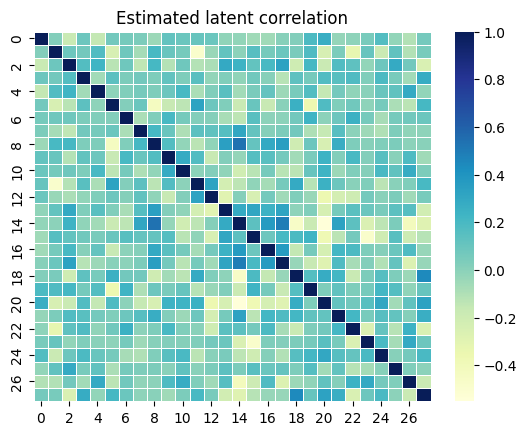

In [28]:
tps = ['tru' for i in range(ec_rrna.shape[1])]
ec_est = latentcor(ec_rrna.layers['sqrt_counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [29]:
ec_rrna_ggl_latentcor = gg_lasso_network_analysis(N=ec_rrna.shape[0], estimate=ec_est)
ec_rrna_ggl_latentcor.create_problem(S_col="R", latent=False)
ec_rrna_ggl_latentcor.model_selection(lambda1_range=np.logspace(0, -6, 200))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 23 iterations with 

In [30]:
ec_rrna_sol_latentcor = ec_rrna_ggl_latentcor.P.solution.precision_ * -1

<Axes: >

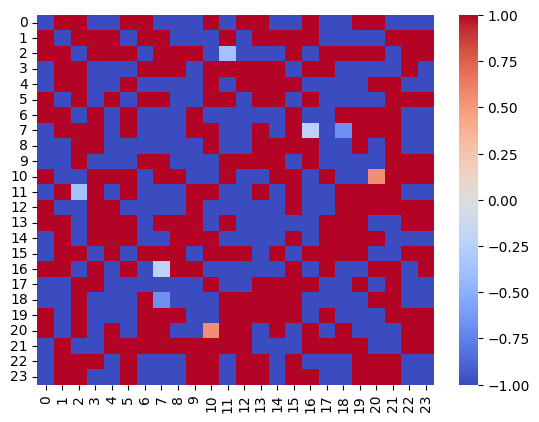

In [31]:
sns.heatmap(ec_sol_latentcor, cmap="coolwarm", vmin=-1, vmax=1)

In [32]:
def extract_part(text):
    return ' '.join(text.split()[1:-5])

ec_rrna.var["short_protein_name"] = ec_rrna.var["protein_name"].apply(lambda x: extract_part(x))

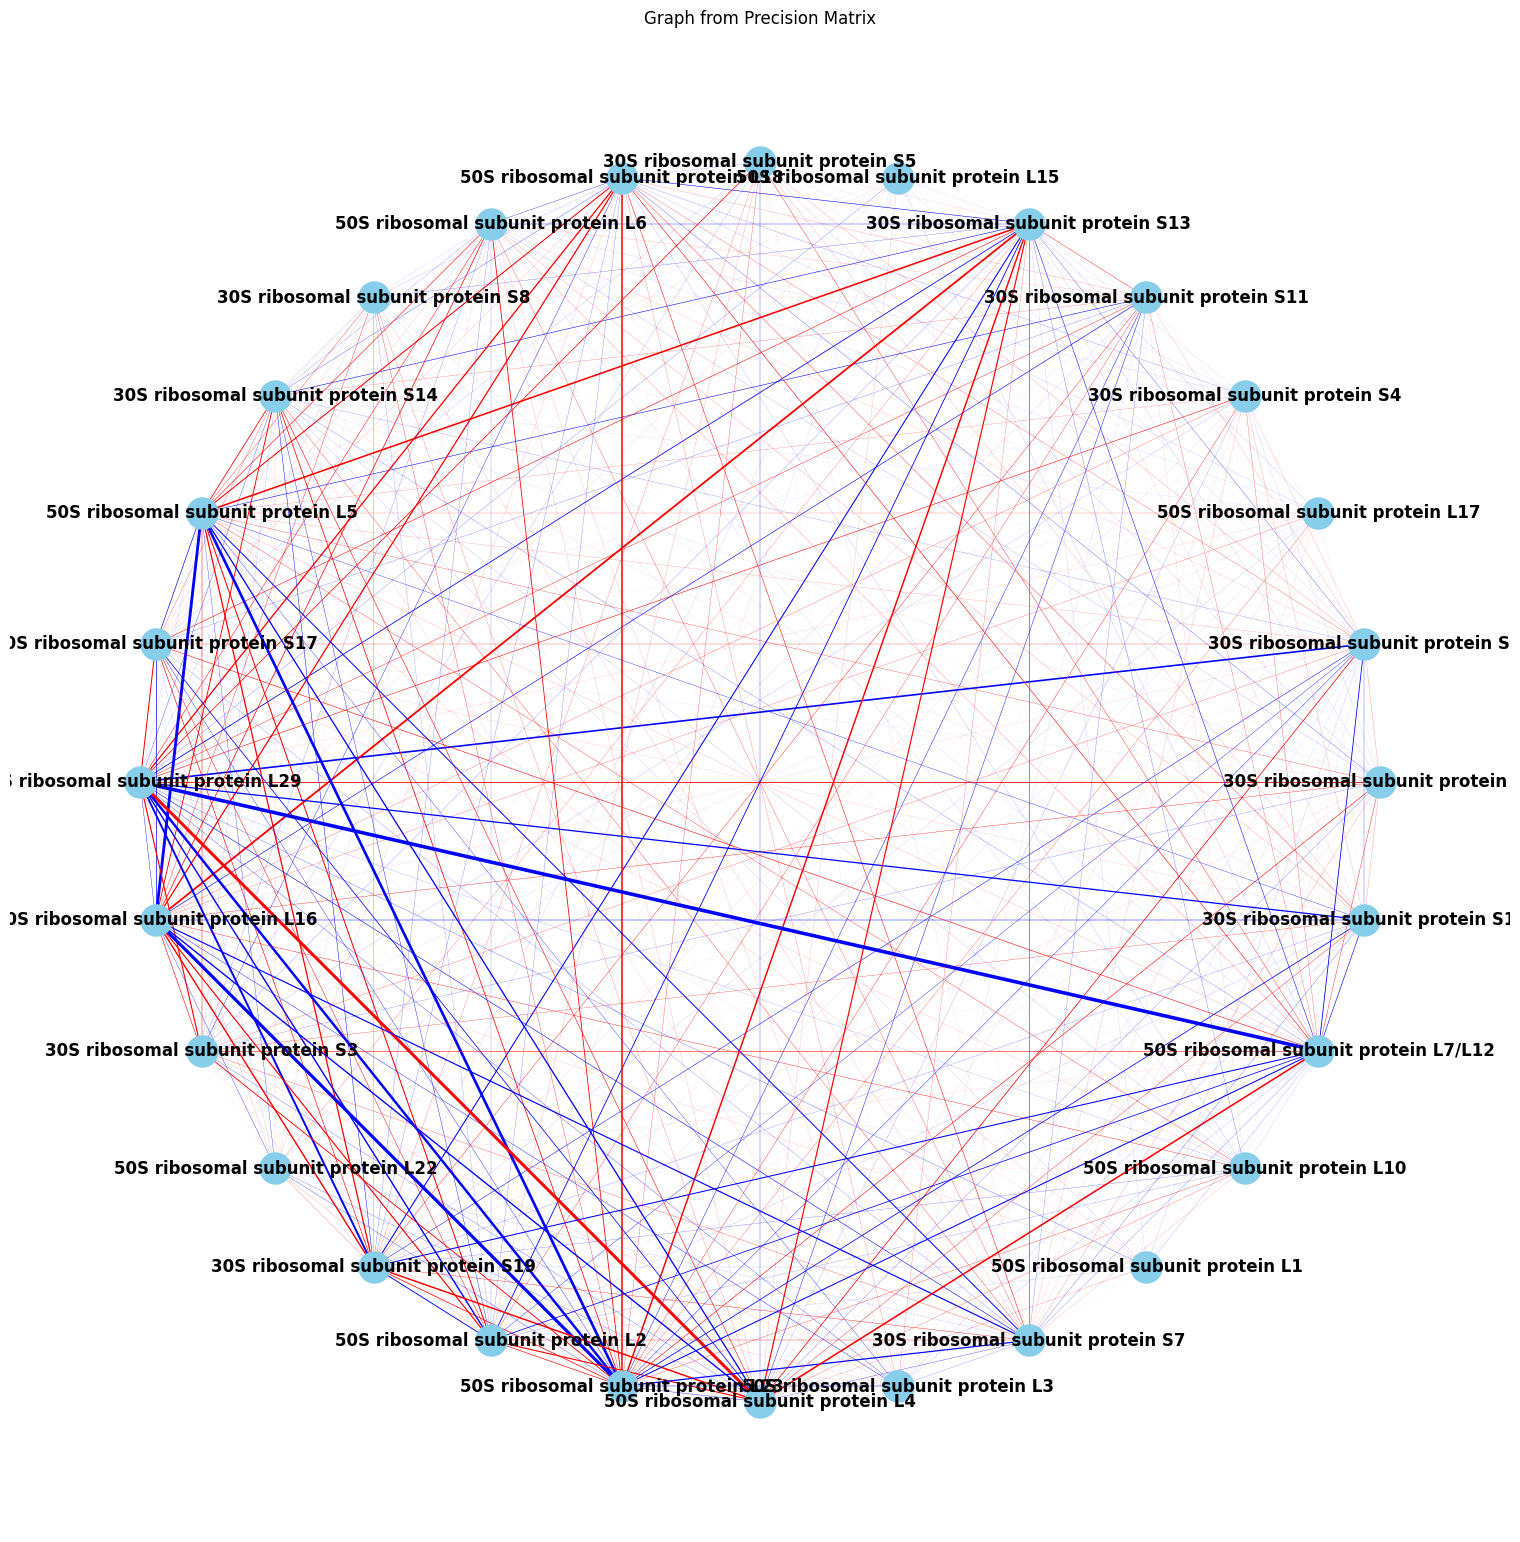

In [34]:
ec_G = nx.Graph()

# Add nodes to the graph
for idx, row in ec_rrna.var.iterrows():
    ec_G.add_node(row['short_protein_name'])

# Add edges to the graph based on the weights
n = len(ec_rrna.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = ec_rrna_sol_latentcor[i, j]
        if weight != 0:
            ec_G.add_edge(ec_rrna.var.iloc[i]['short_protein_name'], ec_rrna.var.iloc[j]['short_protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in ec_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight


# Draw the graph
pos = nx.circular_layout(ec_G)
plt.figure(figsize=(15, 15))
nx.draw(ec_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

In [104]:
def extract_part(text):
    parts = text.split()
    return parts[2] + "-" + parts[5]  # Remove the last part

In [118]:
efm_adata.var["short_protein_name"] = efm_adata.var["protein_name"].apply(lambda x: extract_part(x))
efm_adata.var["short_protein_name"] = efm_adata.var["short_protein_name"].astype(str)
efm_adata.var.loc["cds-WP_138820979.1", "short_protein_name"] = "30S-S6"
efm_adata.var.loc["cds-WP_002288673.1", "short_protein_name"] = "30S-S14"
efm_adata.var.loc["cds-WP_002290330.1", "short_protein_name"] = "50S-L31"

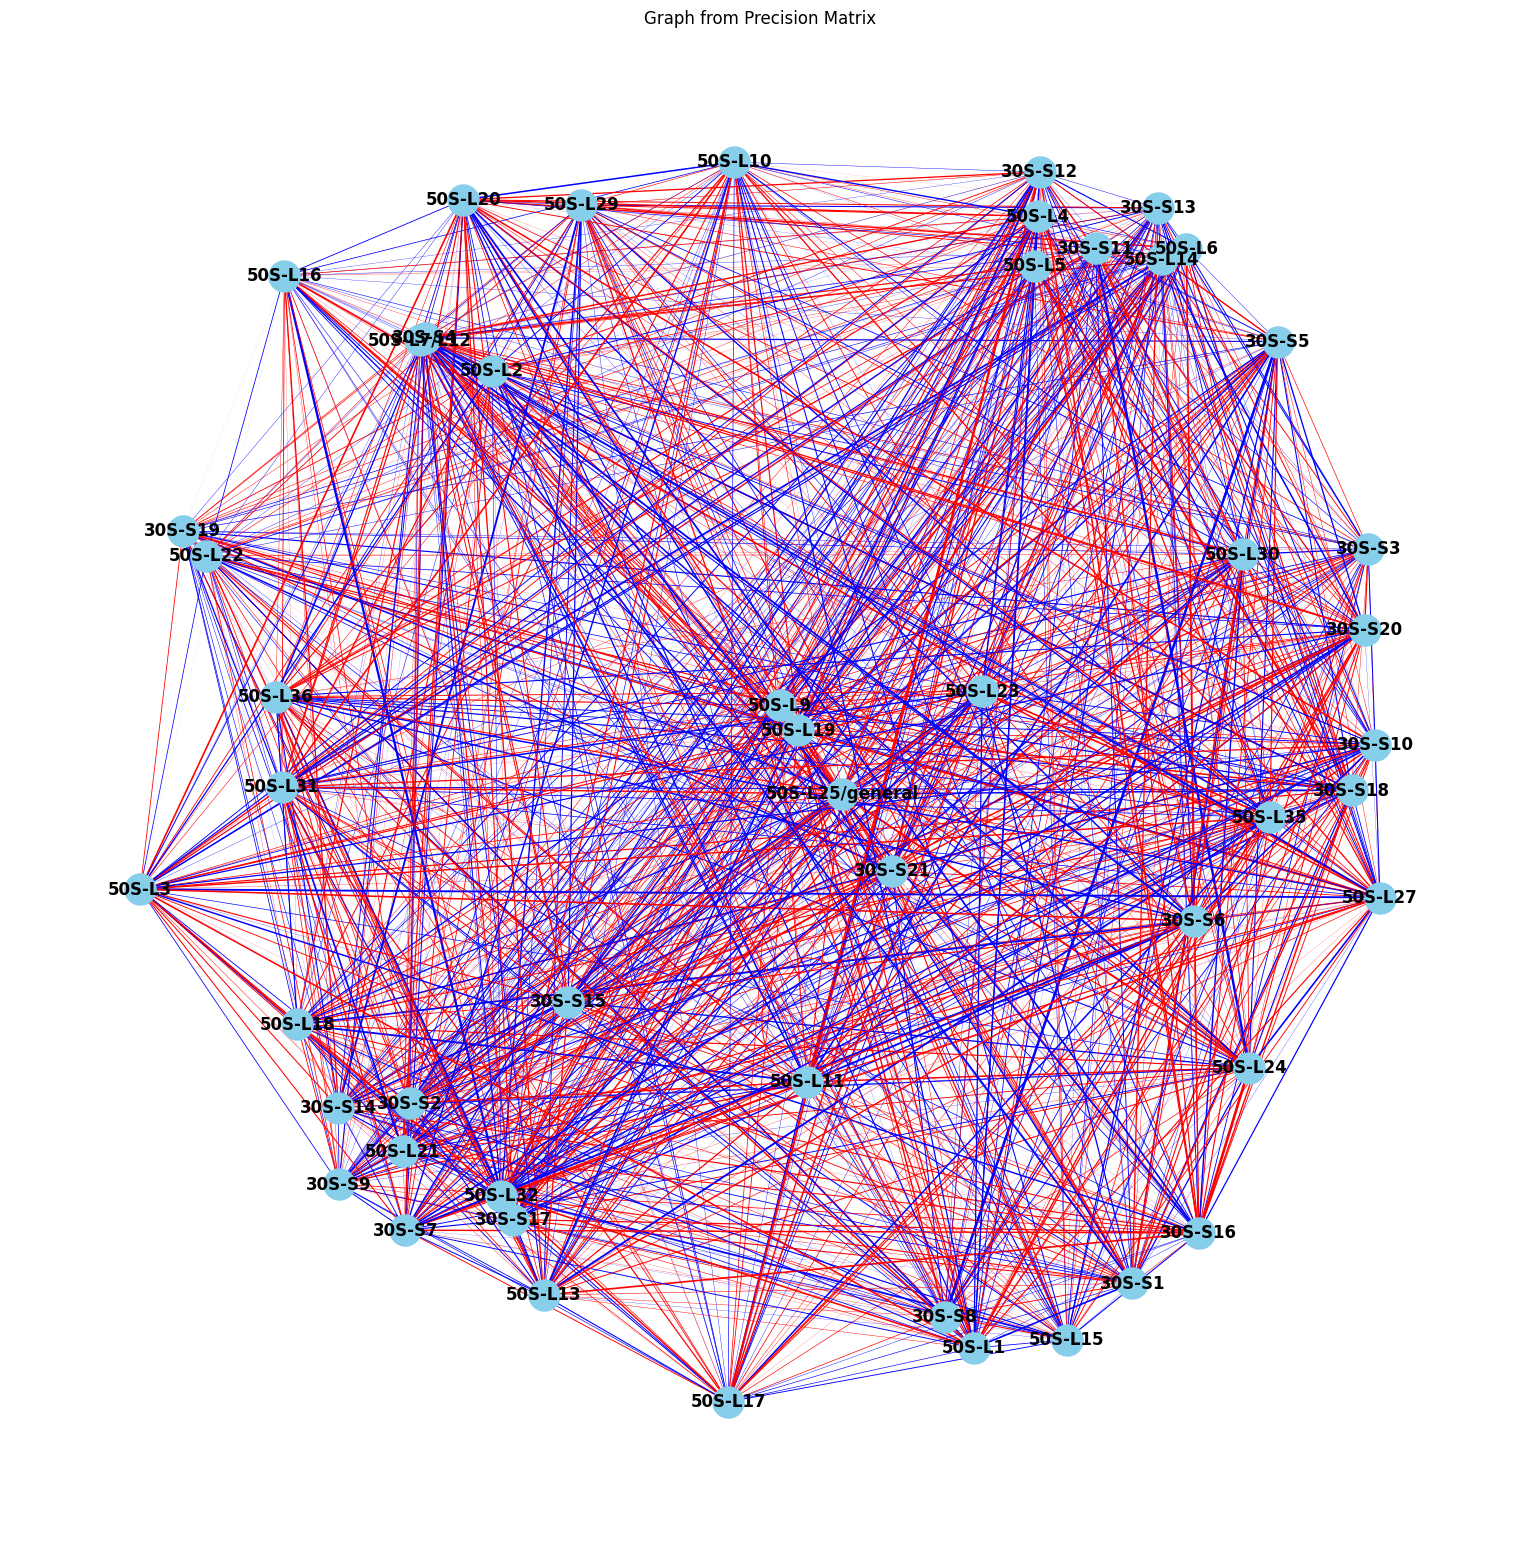

In [148]:
efm_G = nx.Graph()

# Add nodes to the graph
for idx, row in efm_adata.var.iterrows():
    efm_G.add_node(row['short_protein_name'])

# Add edges to the graph based on the weights
n = len(efm_adata.var)
for i in range(n):
    for j in range(i + 1, n):
        weight = efm_sol_latentcor[i, j]
        if weight != 0:
            efm_G.add_edge(efm_adata.var.iloc[i]['short_protein_name'], efm_adata.var.iloc[j]['short_protein_name'], weight=weight)

# Set edge colors based on weight sign
edge_colors = []
edge_widths = []
for edge in efm_G.edges(data=True):
    weight = edge[2]['weight']
    if weight > 0:
        edge_colors.append('red')  # Positive edge
    elif weight < 0:
        edge_colors.append('blue')  # Negative edge
    #edge_widths.append(abs(weight) * 0.01)  # Scale width based on weight
    edge_widths.append(np.log10(abs(weight) * 0.1))
# Draw the graph
pos = nx.spring_layout(efm_G)
plt.figure(figsize=(15, 15))
nx.draw(efm_G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold', 
        edge_color=edge_colors, width=edge_widths)
plt.title('Graph from Precision Matrix')
plt.show()

### Getting the top 5 correlations for both species

<Axes: >

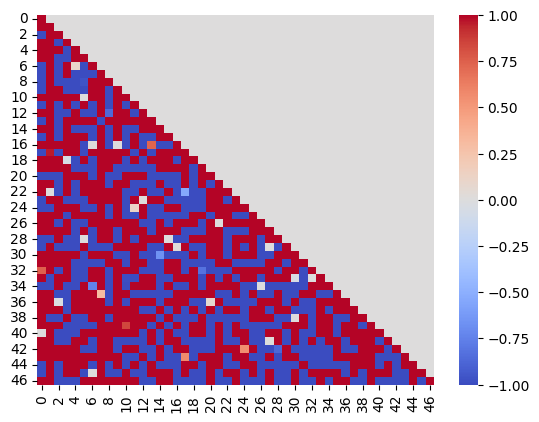

In [48]:
ec_sol_latentcor[np.triu_indices(ec_sol_latentcor.shape[0])] = 0
np.fill_diagonal(ec_sol_latentcor, 1)
sns.heatmap(ec_sol_latentcor, vmin=-1, vmax=1, cmap="coolwarm")

In [49]:
flat_dummy = ec_sol_latentcor.flatten()
ec_top5_corr = np.argsort(flat_dummy)[::-1][:5]

In [50]:
ec_top5_row_indices, ec_top5_col_indices = np.unravel_index(ec_top5_corr, ec_sol_latentcor.shape)

In [51]:
for i in range(5):
    print(f"Top {i+1} entry:")
    print(ec_adata.var.iloc[ec_top5_row_indices[i]][["protein", "protein_name", "PC"]])
    print(ec_adata.var.iloc[ec_top5_col_indices[i]][["protein", "protein_name", "PC"]])
    print("____________________")

Top 1 entry:
protein                              NP_312211.1
protein_name    50S ribosomal subunit protein L4
PC                                 forDFlev63034
Name: cds-NP_312211.1, dtype: object
protein                               NP_312208.1
protein_name    30S ribosomal subunit protein S19
PC                                  forDFlev63141
Name: cds-NP_312208.1, dtype: object
____________________
Top 2 entry:
protein                              NP_312212.1
protein_name    50S ribosomal subunit protein L3
PC                                  forDFlev6724
Name: cds-NP_312212.1, dtype: object
protein                               NP_312191.1
protein_name    50S ribosomal subunit protein L36
PC                                  forDFlev65070
Name: cds-NP_312191.1, dtype: object
____________________
Top 3 entry:
protein                               NP_312935.1
protein_name    50S ribosomal subunit protein L10
PC                                  forDFlev61182
Name: cds-NP_312935.1, dtyp

In [92]:
ec_sol_latentcor[35]

array([ -4.919858  , -14.34383569,   4.31911397,   3.40784298,
       -11.41588984, -11.38926665, -10.17549075,  -0.        ,
        11.62354933,  -0.        ,  -1.01752286,   2.84683721,
        -0.        ,   3.15056025,   0.        ,  10.44495945,
        -3.03221696,  -3.21742513, -10.4082682 ,  -5.00856495,
       -14.0175118 ,   5.17465721,   1.74727644,  -1.39140981,
        12.26872324,  -0.57738008,  24.87335332,  17.40989512,
       -17.64923601,  11.29916439,   6.78626905,  -8.89131223,
       -30.87358068,  -0.        ,  -0.        ,  52.09214324,
        -1.807367  ,  -8.38129002,   2.93749641,  22.00795608,
         0.        ,   0.        , -11.91690422,  -7.55010732,
        -0.        ,  -9.14152051,  -5.92598324])

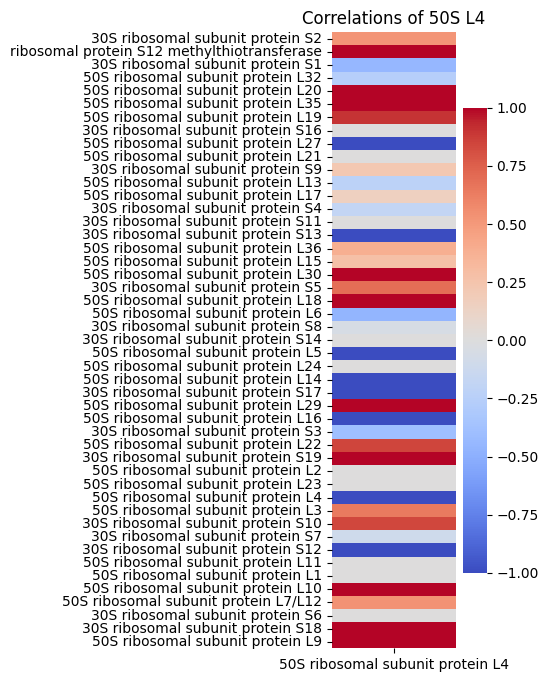

In [99]:
plt.figure(figsize=(2, 8))
ax = sns.heatmap(pd.DataFrame(ec_sol_latentcor[35]*-1), 
                 cmap="coolwarm", vmin=-1, vmax=1,
                 yticklabels=ec_adata.var["protein_name"],
                 xticklabels=[ec_adata.var.iloc[35]["protein_name"]])
plt.title('Correlations of 50S L4')
plt.show()

In [57]:
ec_adata.var.iloc[35]

strains                                 GSM5456506_Kp_CDS
matchin_protein                                     match
protein                                       NP_312211.1
n_cells                                               872
protein_name             50S ribosomal subunit protein L4
rRNA                                                 True
n_cells_by_counts                                     535
mean_counts                                      0.254754
pct_dropout_by_counts                           78.803487
total_counts                                        643.0
n_counts                                            643.0
PC                                          forDFlev63034
Name: cds-NP_312211.1, dtype: object

<Axes: >

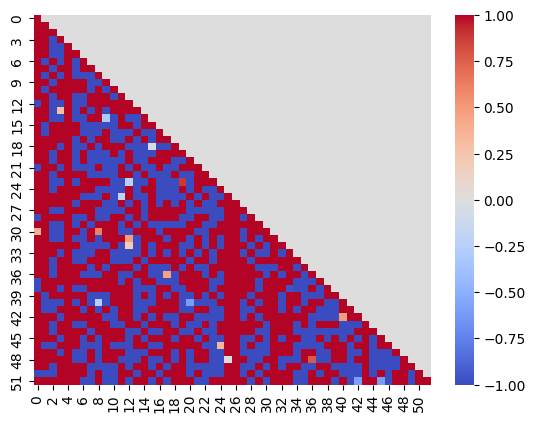

In [52]:
efm_sol_latentcor = efm_sol_latentcor*-1
efm_sol_latentcor[np.triu_indices(efm_sol_latentcor.shape[0])] = 0
np.fill_diagonal(efm_sol_latentcor, 1)
sns.heatmap(efm_sol_latentcor, vmin=-1, vmax=1, cmap="coolwarm")

In [53]:
flat_dummy = efm_sol_latentcor.flatten()
efm_top5_corr = np.argsort(flat_dummy)[::-1][:5]

In [54]:
efm_top5_row_indices, efm_top5_col_indices = np.unravel_index(efm_top5_corr, efm_sol_latentcor.shape)

In [55]:
for i in range(5):
    print(f"Top {i+1} entry:")
    print(efm_adata.var.iloc[efm_top5_row_indices[i]][["protein", "protein_name", "PC"]])
    print(efm_adata.var.iloc[efm_top5_col_indices[i]][["protein", "protein_name", "PC"]])
    print("____________________")

Top 1 entry:
protein                   WP_002287505.1
protein_name    30S ribosomal protein S9
PC                         forDFlev64834
Name: cds-WP_002287505.1, dtype: object
protein                    WP_002287321.1
protein_name    30S ribosomal protein S21
PC                           forDFlev6102
Name: cds-WP_002287321.1, dtype: object
____________________
Top 2 entry:
protein                    WP_002290449.1
protein_name    50S ribosomal protein L23
PC                          forDFlev67218
Name: cds-WP_002290449.1, dtype: object
protein                    WP_002289309.1
protein_name    50S ribosomal protein L35
PC                          forDFlev62492
Name: cds-WP_002289309.1, dtype: object
____________________
Top 3 entry:
protein                    WP_002295975.1
protein_name    50S ribosomal protein L13
PC                          forDFlev64086
Name: cds-WP_002295975.1, dtype: object
protein                    WP_002290274.1
protein_name    30S ribosomal protein S16
PC      